# Coffea Processors
This is a rendered copy of [processor.ipynb](https://github.com/CoffeaTeam/coffea/blob/master/binder/processor.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fprocessor.ipynb)

Coffea relies mainly on [uproot](https://github.com/scikit-hep/uproot) to provide access to ROOT files for analysis.
As a usual analysis will involve processing tens to thousands of files, totalling gigabytes to terabytes of data, there is a certain amount of work to be done to build a parallelized framework to process the data in a reasonable amount of time. Of course, one can work directly within uproot to achieve this, as we'll show in the beginning, but coffea provides the `coffea.processor` module, which allows users to worry just about the actual analysis code and not about how to implement efficient parallelization, assuming that the parallization is a trivial map-reduce operation (e.g. filling histograms and adding them together). The module provides the following key features:

 * A `ProcessorABC` abstract base class that can be derived from to implement the analysis code;
 * An interface to the arrays being read from the TTree, either [DataFrame](https://coffeateam.github.io/coffea/api/coffea.processor.LazyDataFrame.html#coffea.processor.LazyDataFrame) or [NanoEvents](https://coffeateam.github.io/coffea/api/coffea.nanoaod.NanoEvents.html#coffea.nanoaod.NanoEvents), to be used as inputs;
 * A set of accumulator types (value_accumulator, list_accumulator, set_accumulator, dict_accumulator, defaultdict_accumulator, column_accumulator) as described further [here](https://coffeateam.github.io/coffea/modules/coffea.processor.html#classes) to be used as output; and
 * A set of parallel executors to access multicore processing or distributed computing systems such as [Dask](https://distributed.dask.org/en/latest/), [Parsl](http://parsl-project.org/), [Spark](https://spark.apache.org/), and others.

Let's start by writing a simple processor class that reads some CMS open data and plots a dimuon mass spectrum.
We'll start by copying the [ProcessorABC](https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html#coffea.processor.ProcessorABC) skeleton and filling in some details:

 * Remove `flag`, as we won't use it
 * Adding a new histogram for $m_{\mu \mu}$
 * Building a [JaggedCandidateArray](https://coffeateam.github.io/coffea/api/coffea.analysis_objects.JaggedCandidateMethods.html#coffea.analysis_objects.JaggedCandidateMethods.candidatesfromcounts) for muons,
 * Calculating the dimuon invariant mass

In [1]:
from coffea import hist, processor
from coffea.analysis_objects import JaggedCandidateArray

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "mass": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("mass", "$m_{\mu\mu}$ [GeV]", 60, 60, 120),
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()

        dataset = df['dataset']
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content,
            eta=df['Muon_eta'].content,
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            charge=df['Muon_charge'].content,
        )

        cut = (muons.counts == 2) & (muons['charge'].prod() == -1)        
        dimuons = muons[cut].choose(2)
        
        output["sumw"][dataset] += df.size
        output["mass"].fill(
            dataset=dataset,
            mass=dimuons.mass.flatten(),
        )

        return output

    def postprocess(self, accumulator):
        return accumulator

If we were to just use bare uproot to execute this processor, we could do that with the following example, which:

 * Opens a CMS open data file
 * Creates a lazy data frame (roughly equivalent to [uproot.lazyarrays](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot.tree.lazyarrays) but with some specializations needed for othere execution environments)
 * Creates a `MyProcessor` instance
 * Runs the `process()` function, which returns our accumulators


In [2]:
import uproot

filename = "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root"
file = uproot.open(filename)
df = processor.LazyDataFrame(
    tree=file["Events"],
    entrystart=0,
    entrystop=10000,
)
df["dataset"] = "DoubleMuon"
p = MyProcessor()
out = p.process(df)
out

{'sumw': defaultdict_accumulator(float, {'DoubleMuon': 10000.0}),
 'mass': <Hist (dataset,mass) instance at 0x1074336d0>}

One could expand on this code to run over several chunks of the file, setting `entrystart` and `entrystop` as appropriate. Then, several datasets could be processed by iterating over several files. However, [run_uproot_job](https://coffeateam.github.io/coffea/api/coffea.processor.run_uproot_job.html#coffea.processor.run_uproot_job) can help with this. One lists the datasets and corresponding files, the processor they want to run, and which executor they want to use. Available executors are listed [here](https://coffeateam.github.io/coffea/modules/coffea.processor.html#functions). Since these files are very large, we limit to just reading the first few chunks of events from each dataset with `maxchunks`.

In [3]:
fileset = {
    'DoubleMuon': [
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root',
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root',
    ],
    'ZZ to 4mu': [
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/ZZTo4mu.root'
    ]
}

out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    maxchunks=4,
)
out

{'sumw': defaultdict_accumulator(float,
                         {'ZZ to 4mu': 399752.0, 'DoubleMuon': 400224.0}),
 'mass': <Hist (dataset,mass) instance at 0x12337e110>}

Now, if we want to use more than a single core on our machine, we simply change [iterative_executor](https://coffeateam.github.io/coffea/api/coffea.processor.iterative_executor.html) for [futures_executor](https://coffeateam.github.io/coffea/api/coffea.processor.futures_executor.html), which uses the python [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) standard library. Optional arguments to these executors can be provided via `executor_args` parameter of `run_uproot_job`, such as the number of cores to use (2):

In [4]:
out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=MyProcessor(),
    executor=processor.futures_executor,
    executor_args={'workers': 2},
    maxchunks=4,
)
out

{'sumw': defaultdict_accumulator(float,
                         {'ZZ to 4mu': 399752.0, 'DoubleMuon': 400224.0}),
 'mass': <Hist (dataset,mass) instance at 0x106bb6890>}

Hopefully this ran faster than the previous cell, but that may depend on how many cores are available on the machine you are running this notebook.

## Getting fancy
Let's flesh out this analysis into a 4-muon analysis, searching for diboson events:

In [5]:
import numpy as np
import awkward as ak

class FancyDimuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        mass_axis = hist.Bin("mass", r"$m_{\mu\mu}$ [GeV]", 600, 0.25, 300)
        pt_axis = hist.Bin("pt", r"$p_{T,\mu}$ [GeV]", 3000, 0.25, 300)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("Counts", dataset_axis, mass_axis),
            'mass_near': hist.Hist("Counts", dataset_axis, mass_axis),
            'mass_far': hist.Hist("Counts", dataset_axis, mass_axis),
            'pt_lead': hist.Hist("Counts", dataset_axis, pt_axis),
            'pt_trail': hist.Hist("Counts", dataset_axis, pt_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'],
            eta=df['Muon_eta'],
            phi=df['Muon_phi'],
            mass=df['Muon_mass'],
            charge=df['Muon_charge'],
            softId=df['Muon_softId'],
            tightId=df['Muon_tightId']
            )        
        
        output['cutflow']['all events'] += muons.size
        
        soft_id = (muons.softId > 0)
        muons = muons[soft_id]
        output['cutflow']['soft id'] += soft_id.any().sum()
        
        twomuons = (muons.counts >= 2)
        output['cutflow']['two muons'] += twomuons.sum()
        
        dimuons = muons[twomuons].distincts()
        
        twodimuons = (dimuons.counts >= 2)
        output['cutflow']['>= two dimuons'] += twodimuons.sum()
        dimuons = dimuons[twodimuons]
        
        opposite_charge = (dimuons.i0['charge'] * dimuons.i1['charge'] == -1)
        
        dimuons = dimuons[opposite_charge]
        output['cutflow']['opposite charge'] += opposite_charge.any().sum()
        
        mass_20GeV = (dimuons.mass > 35)
        dimuons = dimuons[mass_20GeV]
        
        exactlytwodimuons = (dimuons.counts == 2)
        output['cutflow']['== two dimuons'] += exactlytwodimuons.sum()
        dimuons = dimuons[exactlytwodimuons].compact()
        
        leading_mu = (dimuons.i0.pt.content > dimuons.i1.pt.content)
        pt_lead = ak.JaggedArray.fromoffsets(
            dimuons.offsets,
            np.where(leading_mu, dimuons.i0.pt.content, dimuons.i1.pt.content)
        )
        pt_trail = ak.JaggedArray.fromoffsets(
            dimuons.offsets,
            np.where(~leading_mu, dimuons.i0.pt.content, dimuons.i1.pt.content)
        )
        
        near_z = np.abs(dimuons.mass - 91.118).argmin()
        far_z = np.abs(dimuons.mass - 91.118).argmax()
        
        output['mass'].fill(dataset=dataset,
                            mass=dimuons.p4.sum().mass)
        output['mass_near'].fill(dataset=dataset, 
                                 mass=dimuons.mass[near_z].flatten())
        output['mass_far'].fill(dataset=dataset, 
                                mass=dimuons.mass[far_z].flatten())
        output['pt_lead'].fill(dataset=dataset,
                               pt=pt_lead.flatten())
        output['pt_trail'].fill(dataset=dataset,
                                pt=pt_trail.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [6]:
import time

tstart = time.time()    

fileset = {
    'DoubleMuon': [
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root',
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root',
    ],
    'ZZ to 4mu': [
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/ZZTo4mu.root'
    ]
}

output = processor.run_uproot_job(
    fileset,
    treename='Events',
    processor_instance=FancyDimuonProcessor(),
    executor=processor.futures_executor,
    executor_args={'workers': 6, 'flatten': True},
    chunksize=100000,
    maxchunks=10,
)

elapsed = time.time() - tstart
print(output)


{'mass': <Hist (dataset,mass) instance at 0x106bb6dd0>, 'mass_near': <Hist (dataset,mass) instance at 0x106bb6710>, 'mass_far': <Hist (dataset,mass) instance at 0x106bb6b50>, 'pt_lead': <Hist (dataset,pt) instance at 0x106bb6f10>, 'pt_trail': <Hist (dataset,pt) instance at 0x106bb6910>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 1999940, 'soft id': 1803995, 'two muons': 1394358, '>= two dimuons': 584764, 'opposite charge': 576563, '== two dimuons': 158843})}


What follows is just us looking at the output, you can execute it if you wish

(0.0, 3000.0)

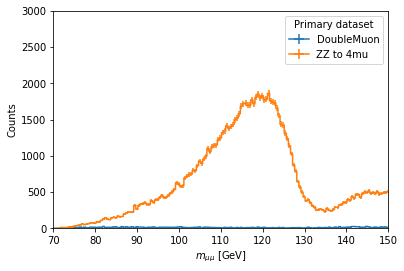

In [7]:
%matplotlib inline

ax = hist.plot1d(output['mass'], overlay='dataset')
ax.set_xlim(70,150)
ax.set_ylim(0, 3000)

(0.1, 7500.0)

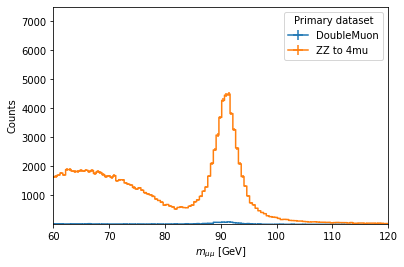

In [8]:
ax = hist.plot1d(output['mass_near'], overlay='dataset')
ax.set_xlim(60,120)
ax.set_ylim(0.1, 7500)

(0.1, 8000)

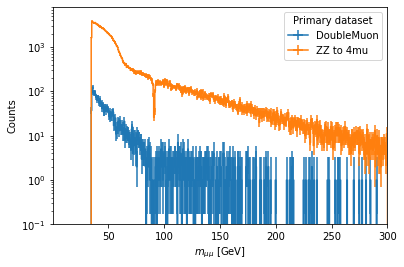

In [9]:
ax = hist.plot1d(output['mass_far'], overlay='dataset')
ax.set_yscale('log')
ax.set_ylim(0.1, 8000)

(0.1, 5000.0)

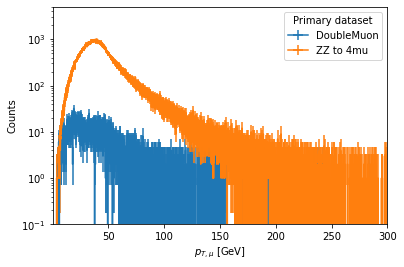

In [10]:
ax = hist.plot1d(output['pt_lead'], overlay='dataset')
ax.set_yscale('log')
ax.set_ylim(0.1, 5e3)

(0.1, 20000.0)

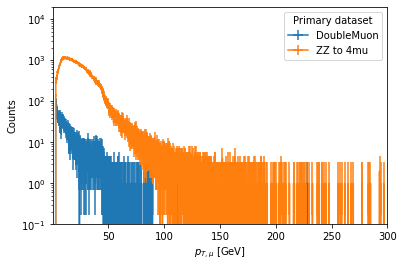

In [11]:
ax = hist.plot1d(output['pt_trail'], overlay='dataset')
ax.set_yscale('log')
ax.set_ylim(0.1, 2e4)

In [12]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 31703.135042905807
